# C4AI Scholars Program Takehome Challenge


### Background

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of three parts:

* Part One of the challenge requires identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
* Part Two of the challenge tests your ability to generate code for a specified problem. 
* Part Three of the challenge is an opportunity for you to attempt an optional challenge question that extends the original problem set. 


These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources. 

Good luck! If you have questions about the framing of the questions, please contact info@for.ai  


### How to Use and Submit this Document

* **Make a copy of this document** and **rename** it **Firstname_Lastname_C4AIScholarsChallenge**
* Once you’ve completed all tasks, **save and pin your revisions**
* **Submit a link** to your final document via the [Cohere For AI Scholars Program application](https://jobs.lever.co/cohere/?department=Cohere%20For%20AI). 



---



## Overview of Singular Value Decomposition

In this takehome, you will be working on a problem involving singular value decomposition. Singular Value Decomposition (SVD) exists for every rectangular matrix. The nice thing about SVD is that the original matrix can be expressed as the sum of outer products of left and singular vectors scaled by the corresponding singular values. Formally:

> Let 𝛢 be a rectangular matrix of dimensions 𝑚𝘹𝑛, then the SVD of the matrix A is given by $ A = U𝛴V^T$ where $U$ is an orthogonal matrix of shape mxm containing the left singular vectors, $V$ is an orthogonal matrix of shape nxn containing the right singular vectors and $𝛴$ is a diagonal matrix containing the singular values of $A$. This formulation of SVD can be re-expressed as \begin{align} A = \sum_{i=1}^{r} s_i. u_i v_i^T \end{align} where $r = \text{min}(m,n)$ represents the rank of the matrix, $s_i$ is the $i$th singular value and $u_i v_i^T$ is the outer product of the $i$th left and right singular vectors. 

<!-- \begin{align}
A = \sum_{i=1}^{\text{min}(m,n)} s_i. u_i v_i^T
\end{align}
\begin{align} -->

> The singular values $𝛴$ are decreasing in order. So, each outer product is scaled by a smaller value as we compute each term in the sum above. This gives us an opportunity to approximate $A$ using only the sum of the first $k$ outer products where $k < \text{min}(m,n)$ $-$ this effectively means that we are zero-ing out some of the singular values by assuming that the contribution to the sum is negligible. This is called low-rank approximation.

If you aren't familiar with singular value decomposition, or the above feels rusty, don't worry. Take a moment to brush up your knowledge using any of the following resources:
* [stanford lecture notes on low rank approximations](https://web.stanford.edu/class/cs168/l/l9.pdf)
* [youtube series of short and beginner friendly lectures](https://www.youtube.com/watch?v=gXbThCXjZFM&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv)



## Check for understanding (3 points)

#### Q1: What are some real world applications of low rank approximations?


#### Answer: It can be used in dimensionality reduction where a matrix is represented by the highest modes (sigma in the above euation), for example it can be used in image compression. It can also be used to understand the relationship between two elements represented in the original matrix where the rows of the matrix represents the first element and the columns represents the second.


#### Q2: What are the benefits of compressing a deep neural network? How would you measure the benefits of compression?


#### Answer: The major benefits of compressing a deep neural networks is compressing the model size, how much mmemory it would take after compression compared to the original model without losing much of its output efficincy. Another benifits is the computational cost, as it decrease the number of required compuation such as the multiplication to produce the output. To measure the benefits of compression would be the ability to deploy the models on small device without taking too much memory or draining too much power.

#### Q3: In this takehome, we will consider how singular value decomposition can be used to compress a deep neural network. Compared to other compression methods used for deep neural networks such as pruning, quantization, or efficient architectures, what are the relative merits/demerits of low rank approximations? Choose one or two alternative compression methods and compare with singular value decomposition.

#### Answer: Pruning techniques are done by either prune the neurons under certain threshold or prune a percentage of the connections. It requires manual steup of sensitivity for layers to determince the pruned connections and demand fine-tuning for the left parameters. Low rank approximation is computationaly expensive and it performs the approximation layer by layer, so it can't perform global parameter compression which is important as different layers hold different information. 



---



### Imports

In [ ]:
!pip install dm-haiku optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 350 kB 24.0 MB/s 
     |████████████████████████████████| 145 kB 45.1 MB/s 
     |████████████████████████████████| 85 kB 1.5 MB/s 


In [ ]:
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math

Batch = Tuple[np.ndarray, np.ndarray]



---




## Coding Challenge Part I : Debugging Challenge (10 Points)


We are now going to explore using SVD to compute low rank approximations of the parameters of a small deep neural network. You are using a very simple toy model as a first baseline. Section 3 will give you the chance to improve baseline accuracy beyond this very simple model -- this is just a toy setting to first explore low rank approximations.

The first part of this challenge is primarily a debugging challenge. It will require removing bugs in order to train a very simple network. We have introduced several bugs -- some are subtle and will not break your code but will degrade final performance. These subtle bugs are introduced to understand your grasp of fundamental machine learning principles. There are also more obvious bugs designed to break your code. 

* [**4 points**] Your goal is to get the code working. There are 4 bugs in the code, these are subtle bugs which are designed to impair test accuracy but not break the code. You will get partial points for each of the 4 bugs you find. After finding all bugs, your test performance should be around 66-67% test accuracy.

* [**2 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs. 

* [**4 points**] There are also two functions you will need to code up in this section -- we indicate where these code changes need to happen with TODO comments. 

* Do not alter the model architecture or the learning rate.

In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)


def net_fn(batch: Batch) -> jnp.ndarray:
  """ This function define the neural network architecture"""
  x = normalize(batch[0])
  
  # Do NOT alter the architecture definition below.
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(10),
  ])
  return net(x)

def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Iterator[tuple]:
  """Loads the dataset as a generator of batches."""
  ds = tfds.load('cifar10', split=split, as_supervised=True).cache().repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

def compute_loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """Compute the loss of the network, including L2."""
  x, y = batch
  logits = net.apply(params, batch)
  labels = jax.nn.one_hot(y, 10)

  # TODO: add code below to compute the l2_loss variable
  l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
  weighted_l2_loss = 0.5 * l2_loss
  
  softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits)) 
  # Bug Alert: weighted L2 regurlarization term should be used not the L2
  return softmax_xent - (1e-4 * weighted_l2_loss)


@jax.jit
def compute_accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  x, y = batch
  # The output of the model is the prob. of each class
  logits = net.apply(params, batch)
  # The predictions choose the class with the highest prob.
  predictions = jnp.argmax(logits, axis=-1)

  # TODO: add code below to compute the accuracy over the batch.
  x, y = batch
  accuracy = jnp.mean(predictions == y)
  return accuracy

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
  """ This function claculates the gradient of the architecure with respect to the loss """
  grads = jax.grad(compute_loss)(params, batch)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  """ This function update the parameters with step size """
  return optax.incremental_update(params, avg_params, step_size=0.001)


def normalize(images):
  """ Normalization of the dataset into a mean of zero and std of one """
  mean = np.asarray(CIFAR10_MEAN)
  std = np.asarray(CIFAR10_STD)
  # Bug Alert: casting the image into int type make it lose information it has to be float
  x = images.astype(jnp.float32) / 255.
  # Bug Alert: normalization is done by subtracting the mean and dividing by the std
  x -= mean
  x /= std

  return x

### Training

In [ ]:
net = hk.without_apply_rng(hk.transform(net_fn))

# Do not change learning rate
opt = optax.adam(1e-3)

# Bug Alert: the model is trained on 20 % on the training data and the rest 80% is used for validation it should be vice versa
train = load_dataset("train[0%:80%]", is_training=True, batch_size=1000)
validation = load_dataset("train[80%:]", is_training=False, batch_size=10000)
test = load_dataset("test", is_training=False, batch_size=10000)

params = avg_params = net.init(jax.random.PRNGKey(42), next(train))
opt_state = opt.init(params)

for step in range(10001):
  if step % 1000 == 0:
    val_accuracy = compute_accuracy(avg_params, next(validation))
    test_accuracy = compute_accuracy(avg_params, next(test))
    val_accuracy, test_accuracy = jax.device_get(
        (val_accuracy, test_accuracy))
    print(f"[Step {step}] Validation / Test accuracy: "
          f"{val_accuracy:.3f} / {test_accuracy:.3f}.")

  params, opt_state = update(params, opt_state, next(train))
  avg_params = ema_update(params, avg_params)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteHKS9NY/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteHKS9NY/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
[Step 0] Validation / Test accuracy: 0.101 / 0.103.
[Step 1000] Validation / Test accuracy: 0.471 / 0.475.
[Step 2000] Validation / Test accuracy: 0.614 / 0.613.
[Step 3000] Validation / Test accuracy: 0.632 / 0.631.
[Step 4000] Validation / Test accuracy: 0.639 / 0.634.
[Step 5000] Validation / Test accuracy: 0.637 / 0.627.
[Step 6000] Validation / Test accuracy: 0.635 / 0.634.
[Step 7000] Validation / Test accuracy: 0.631 / 0.638.
[Step 8000] Validation / Test accuracy: 0.633 / 0.634.
[Step 9000] Validation / Test accuracy: 0.633 / 0.640.
[Step 10000] Validation / Test accuracy: 0.634 / 0.640.




---



## Coding Challenge Part 2: Compression through Low Rank Approximation (8 points)

In this section, you will add code to compute the low rank approximation and to compute evaluation metrics. We will evaluate whether the low rank approximation allows for speed up in inference time. We define inference time as the average time to compute the prediction for all examples in the test set.

* [**4 points**] You will need to add code to define both the compute_eval_metrics and rank_approximated weight function. 
* [**4 points**] Q4 and Q5 are worth 2 points each.

In [ ]:
def compute_eval_metrics(params, batch, n_samples):
# TODO: add code to compute the time for inference.
  duration_list = []
  accuracy_list = []
  for _ in range(n_samples):
    start = 0.0
    # TODO: add code to correctly compute the accuracy on a given batch.
    acc = compute_accuracy(params, batch)
    start_time = time.time()
    predictions = jnp.argmax(net.apply(params, batch), axis=-1)
    end_time = time.time()
    duration = end_time - start_time
    duration_list.append(duration)
    accuracy_list.append(acc)

  return accuracy_list, duration_list

In [ ]:
def rank_approximated_weight(weight: jnp.ndarray, rank_fraction: float):
  # TODO: replace the code below with code to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
  u, sigma,v = jnp.linalg.svd(weight, full_matrices=False, compute_uv=True)
  rank = int(rank_fraction * sigma.shape[0])
  u = u[:,:rank] * sigma[:rank]
  v = v[:rank, :]
  
  return u, v

### Evaluations at different ranks

The code below first replaces the weights with the low rank factorizations at different rank fractions. For each modified net, we compute the new eval accuracy. Firstly, add code for the rank_approximated_weight and add code to correctly compute the time for inference (the duration).

In [ ]:
rank_truncated_params = deepcopy(params)
ranks_and_accuracies = []
ranks_and_times = []
for rank_fraction in np.arange(1.0, 0.0, -0.1):

  print(f"Evaluating the model at {rank_fraction}")
  for layer in params.keys():
    if 'conv' in layer:
      continue
    weight = avg_params[layer]['w']
    # TODO: complete coding the rank_approximated_weight function to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
    u, v = rank_approximated_weight(weight, rank_fraction)
    rank_truncated_params[layer]['w'] = u@v

  test_batch = next(test)
  # we compute metrics over 50 samples to reduce noise in the measurement.
  n_samples = 50
  # TODO: complete coding the compute_eval_metrics function to compute the time taken for inference.
  test_accuracy, latency = compute_eval_metrics(rank_truncated_params, next(test), n_samples)
  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Duration: "
          f"{rank_fraction:.2f} / {np.mean(latency):.4f}.")
  ranks_and_times.append((rank_fraction, np.mean(latency)))

Evaluating the model at 1.0
Rank Fraction / Test accuracy: 1.00 / 0.633.
Rank Fraction / Duration: 1.00 / 0.4954.
Evaluating the model at 0.9
Rank Fraction / Test accuracy: 0.90 / 0.620.
Rank Fraction / Duration: 0.90 / 0.5041.
Evaluating the model at 0.8
Rank Fraction / Test accuracy: 0.80 / 0.601.
Rank Fraction / Duration: 0.80 / 0.5138.
Evaluating the model at 0.7000000000000001
Rank Fraction / Test accuracy: 0.70 / 0.563.
Rank Fraction / Duration: 0.70 / 0.5174.
Evaluating the model at 0.6000000000000001
Rank Fraction / Test accuracy: 0.60 / 0.407.
Rank Fraction / Duration: 0.60 / 0.5231.
Evaluating the model at 0.5000000000000001
Rank Fraction / Test accuracy: 0.50 / 0.241.
Rank Fraction / Duration: 0.50 / 0.5290.
Evaluating the model at 0.40000000000000013
Rank Fraction / Test accuracy: 0.40 / 0.095.
Rank Fraction / Duration: 0.40 / 0.5321.
Evaluating the model at 0.30000000000000016
Rank Fraction / Test accuracy: 0.30 / 0.088.
Rank Fraction / Duration: 0.30 / 0.5338.
Evaluating 

### Q4: What do you observe as the relationship between rank fraction and test accuracy?

Plot this relationship showing accuracy (y-axis) vs rank percentage of the matrix (x-axis). You should use the ranks_and_accuracies list computed above.

Answer:

In [ ]:
ranks = []
times = []
accuracy = []
for i in range(len(ranks_and_times)):
  rank_, time_ = ranks_and_times[i]
  _, accuracy_ = ranks_and_accuracies[i]
  ranks.append(rank_)
  times.append(time_)
  accuracy.append(accuracy_)

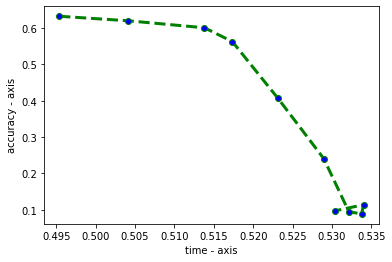

In [ ]:
## TODO: add your code below to plot the relationship between time and test set accuracy
plt.plot(times, accuracy, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue')
plt.xlabel('time - axis')
plt.ylabel('accuracy - axis')
plt.show()

### Q5: Does replacing the weight matrix with the low factor matrix result in latency speed ups?

Plot the relationship of time (y-axis) vs rank percentage (x-axis). To do so add code to compute the ranks_and_times list.

Answer:

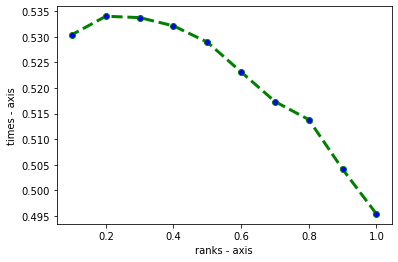

In [ ]:
## TODO: add your code below to plot the relationship between time and rank percentage
plt.plot(ranks, times, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue')
plt.xlabel('ranks - axis')
plt.ylabel('times - axis')
plt.show()

## Coding Challenge Part 3: Perform evaluations on the dataset in factorized space. (4 points)

In this section, you will perform evaluations on the dataset in factorized space.

* [**4 points**] 2 pts for question 6 and question 7.

In [ ]:
def low_rank_net_fn(batch: Batch, rank: float) -> jnp.ndarray:
  
  x = normalize(batch[0])
  total_input_dim = np.prod(x.shape[1:])

  # Do not alter the architecture code.
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(int(rank * min(total_input_dim, 3000)), with_bias=False),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False), 
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False), 
      hk.Linear(2000), jax.nn.relu,      
      hk.Linear(int(rank * 1000), with_bias=False), 
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(int(rank * 10), with_bias=False),
      hk.Linear(10),
  ])
  return net(x)

In [ ]:
vanilla_to_low_rank_map = {
    'conv2_d': 'conv2_d',
    'conv2_d_1': 'conv2_d_1',
    'linear': ['linear', 'linear_1'],
    'linear_1': ['linear_2', 'linear_3'],
    'linear_2': ['linear_4', 'linear_5'],
    'linear_3': ['linear_6', 'linear_7'],
    'linear_4': ['linear_8', 'linear_9']
}


ranks_and_accuracies = []
ranks_and_times = []
for rank_fraction in np.arange(1.0, 0.0, -0.1):
  low_rank_net_fn_partial = partial(low_rank_net_fn, rank=rank_fraction)
  net = hk.without_apply_rng(hk.transform(low_rank_net_fn_partial)) 
  low_rank_params = net.init(jax.random.PRNGKey(42), next(train))

  print(f"Evaluating the model at" f"{rank_fraction:.2f}")

  for layer in vanilla_to_low_rank_map.keys():
    if 'conv' in layer:
      low_rank_params[layer] = params[layer]
      continue
    weight = params[layer]['w']
    # TODO: complete coding the rank_approximated_weight function to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
    u, v = rank_approximated_weight(weight, rank_fraction)
    low_rank_params[vanilla_to_low_rank_map[layer][0]]['w'] = u
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['w'] = v
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['b'] = params[layer]['b']
  
  # TODO: modify the compute_eval_metrics function below to compute the time taken for inference.
  test_accuracy, duration = compute_eval_metrics(low_rank_params, next(test), 50)
  ranks_and_times.append((rank_fraction, np.mean(duration)))
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  print(f"Rank Fraction / Duration: "
          f"{rank_fraction:.2f} / {np.mean(duration):.4f}.")

Evaluating the model at1.00
Rank Fraction / Test accuracy: 1.00 / 0.615.
Rank Fraction / Duration: 1.00 / 0.6979.
Evaluating the model at0.90
Rank Fraction / Test accuracy: 0.90 / 0.610.
Rank Fraction / Duration: 0.90 / 0.7023.
Evaluating the model at0.80
Rank Fraction / Test accuracy: 0.80 / 0.593.
Rank Fraction / Duration: 0.80 / 0.6253.
Evaluating the model at0.70
Rank Fraction / Test accuracy: 0.70 / 0.543.
Rank Fraction / Duration: 0.70 / 0.5815.
Evaluating the model at0.60
Rank Fraction / Test accuracy: 0.60 / 0.366.
Rank Fraction / Duration: 0.60 / 0.5148.
Evaluating the model at0.50
Rank Fraction / Test accuracy: 0.50 / 0.259.
Rank Fraction / Duration: 0.50 / 0.4871.
Evaluating the model at0.40
Rank Fraction / Test accuracy: 0.40 / 0.088.
Rank Fraction / Duration: 0.40 / 0.4820.
Evaluating the model at0.30
Rank Fraction / Test accuracy: 0.30 / 0.086.
Rank Fraction / Duration: 0.30 / 0.4775.
Evaluating the model at0.20
Rank Fraction / Test accuracy: 0.20 / 0.152.
Rank Fraction /

### Q6: Plot a curve showing time vs rank percentage of the matrix 

In [ ]:
ranks = []
times = []
for rank_, time_ in ranks_and_times:
  ranks.append(rank_)
  times.append(time_)

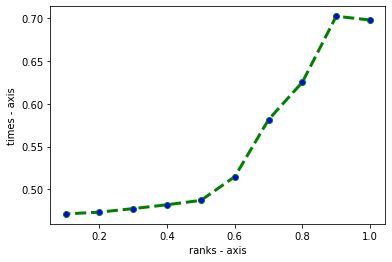

In [ ]:
# TODO: add code to plot the relationship between time vs percentage rank of the matrix.
plt.plot(ranks, times, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue')
plt.xlabel('ranks - axis')
plt.ylabel('times - axis')
plt.show()

### Q7: What do you observe between time and the percentage rank of the matrix.

### Put your answer here:

Time of inference increase with rank increasing, as the number of the network increase with the rank increasing which means more compuational time to get the output of the network.

---



## Coding Challenge Part 4: Take this Further (10 bonus points)

This part of the challenge is designed to be open ended. If you wanted to show some more skills, here is your chance to shine. We include two options below -- **only do one of the options**:

**Option 1:** Implement a change that isn't SVD but minimizes inference latency while preserving accuracy. Can you outperform SVD? 



**Option 2:** Improve the quality of code for this takehome. Pretend you are reviewing a peer and add comments to cells with suggestions of how to improve the code quality. Try and make your comments action orientated and precise. 


**For Option 1, DO NOT alter the previous code sections, instead add any new code below. You should not need to add new code for Option 2, instead just add comments to cells.**


In [ ]:
train = load_dataset("train[0%:80%]", is_training=True, batch_size=1000)
validation = load_dataset("train[80%:]", is_training=False, batch_size=10000)
test = load_dataset("test", is_training=False, batch_size=10000)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteOUSJQM/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteOUSJQM/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# TODO: add code for option 1 here
# Not my code credits to https://github.com/deepmind/dm-haiku/blob/main/examples/mnist_pruning.py
import functools
from typing import Callable, Iterator, Mapping, Sequence, Tuple

Batch = Tuple[np.ndarray, np.ndarray]
Predicate = Callable[[str, str, jnp.ndarray], bool]
PredicateMap = Mapping[Predicate, jnp.ndarray]
ModuleSparsity = Sequence[Tuple[Predicate, jnp.ndarray]]


def topk_mask(value: jnp.ndarray, density_fraction: float) -> jnp.ndarray:
  """Return a mask with 1s marking the top fraction of value.
  """

  def topk_mask_internal(value):
    assert value.ndim == 1
    indices = jnp.argsort(value)
    k = jnp.round(density_fraction * jnp.size(value)).astype(jnp.int32)
    mask = jnp.greater_equal(np.arange(value.size), value.size - k)
    mask = jnp.zeros_like(mask).at[indices].set(mask)
    return mask.astype(np.int32)

  # shuffle value so that identical values aren't always pruned
  # with a bias to lower indices
  orig_shape = value.shape
  value = jnp.reshape(value, -1)
  shuffled_indices = jax.random.shuffle(
      jax.random.PRNGKey(42), jnp.arange(0, jnp.size(value), dtype=jnp.int32))

  shuffled_mask = topk_mask_internal(value[shuffled_indices])
  mask = jnp.zeros_like(shuffled_mask).at[shuffled_indices].set(shuffled_mask)
  mask = jnp.reshape(mask, orig_shape)
  return mask


def zhugupta_func(progress: jnp.ndarray) -> jnp.ndarray:
  """From 'To Prune or Not To Prune' :cite:`zhu2017prune`."""
  return 1. - (1. - progress)**3


def _create_partitions(
    module_sparsity: ModuleSparsity, params: hk.Params
) -> Tuple[Sequence[hk.Params], Sequence[jnp.ndarray], hk.Params]:
  """Partition params based on sparsity_predicate_map.
  """
  list_of_trees = []
  sparsity_list = []

  tail = params
  # Greedily match so that no parameter can be matched more than once
  for predicate, sparsity in module_sparsity:
    head, tail = hk.data_structures.partition(predicate, tail)
    list_of_trees.append(head)
    sparsity_list.append(sparsity)

  return list_of_trees, sparsity_list, tail


def sparsity_ignore(m: str, n: str, v: jnp.ndarray) -> bool:
  """Any parameter matching these conditions should generally not be pruned."""
  # n == 'b' when param is a bias
  return n == "b" or v.ndim == 1 or "batchnorm" in m or "batch_norm" in m


@functools.partial(jax.jit, static_argnums=2)
def apply_mask(params: hk.Params, masks: Sequence[hk.Params],
               module_sparsity: ModuleSparsity) -> hk.Params:
  """Apply existing masks to params based on sparsity_predicate_map.
  """
  params_to_prune, _, params_no_prune = _create_partitions(
      module_sparsity, params)
  pruned_params = []
  for value, mask in zip(params_to_prune, masks):
    pruned_params.append(
        jax.tree_util.tree_map(lambda x, y: x * y, value, mask))
  params = hk.data_structures.merge(*pruned_params, params_no_prune)
  return params


@functools.partial(jax.jit, static_argnums=2)
def update_mask(params: hk.Params, sparsity_fraction: float,
                module_sparsity: ModuleSparsity) -> Sequence[hk.Params]:
  """Generate masks based on module_sparsity and sparsity_fraction."""
  params_to_prune, sparsities, _ = _create_partitions(module_sparsity, params)
  masks = []

  def map_fn(x: jnp.ndarray, sparsity: float) -> jnp.ndarray:
    return topk_mask(jnp.abs(x), 1. - sparsity * sparsity_fraction)

  for tree, sparsity in zip(params_to_prune, sparsities):
    map_fn_sparsity = functools.partial(map_fn, sparsity=sparsity)
    mask = jax.tree_util.tree_map(map_fn_sparsity, tree)
    masks.append(mask)
  return masks


@jax.jit
def get_sparsity(params: hk.Params):
  """Calculate the total sparsity and tensor-wise sparsity of params."""
  total_params = sum(jnp.size(x) for x in jax.tree_util.tree_leaves(params))
  total_nnz = sum(jnp.sum(x != 0.) for x in jax.tree_util.tree_leaves(params))
  leaf_sparsity = jax.tree_util.tree_map(
      lambda x: jnp.sum(x == 0) / jnp.size(x), params)
  return total_params, total_nnz, leaf_sparsity


def module_matching(s):

   def match_func(m, n, k):
     return m.endswith(s) and not sparsity_ignore(m, n, k)

   return match_func

module_sparsity = ((module_matching("linear"), 0.98), (module_matching("linear_1"), 0.9), (module_matching("linear_2"), 0.9), (module_matching("linear_3"), 0.9))

In [ ]:
net = hk.without_apply_rng(hk.transform(net_fn))

# Do not change learning rate
opt = optax.adam(1e-3)

pruned_params = params = avg_params = net.init(
    jax.random.PRNGKey(42), next(train))

masks = update_mask(params, 0., module_sparsity)
opt_state = opt.init(params)

# Train/eval loop.
for step in range(10001):
  if step % 1000 == 0:
    # Periodically evaluate classification accuracy on train & test sets.
    avg_params = apply_mask(avg_params, masks, module_sparsity)
    train_accuracy = compute_accuracy(avg_params, next(validation))
    test_accuracy = compute_accuracy(avg_params, next(test))
    total_params, total_nnz, per_layer_sparsities = get_sparsity(avg_params)
    train_accuracy, test_accuracy, total_nnz, per_layer_sparsities = (
        jax.device_get(
            (train_accuracy, test_accuracy, total_nnz, per_layer_sparsities)))
    print(f"[Step {step}] Train / Test accuracy: "
          f"{train_accuracy:.3f} / {test_accuracy:.3f}.")
    print(f"Non-zero params / Total: {total_nnz} / {total_params}; "
          f"Total Sparsity: {1. - total_nnz / total_params:.3f}")

  # Do SGD on a batch of training examples.
  pruned_params = apply_mask(params, masks, module_sparsity)
  updates, opt_state = update(pruned_params, opt_state, next(train))
  # applying a straight-through estimator here (that is not masking
  # the updates) leads to much worse performance.
  updates = apply_mask(updates, masks, module_sparsity)
  params = optax.apply_updates(params, updates)
  # we start pruning at iteration 1000 and end at iteration 8000
  progress = min(max((step - 1000.) / 8000., 0.), 1.)
  if step % 200 == 0:
    sparsity_fraction = zhugupta_func(progress)
    masks = update_mask(params, sparsity_fraction, module_sparsity)
  avg_params = ema_update(params, avg_params)
print(per_layer_sparsities)

[Step 0] Train / Test accuracy: 0.101 / 0.103.
Non-zero params / Total: 30454146 / 30462226; Total Sparsity: 0.000
[Step 1000] Train / Test accuracy: 0.093 / 0.100.
Non-zero params / Total: 30462041 / 30462226; Total Sparsity: 0.000
[Step 2000] Train / Test accuracy: 0.093 / 0.100.
Non-zero params / Total: 30462041 / 30462226; Total Sparsity: 0.000
[Step 3000] Train / Test accuracy: 0.093 / 0.100.
Non-zero params / Total: 30462041 / 30462226; Total Sparsity: 0.000
[Step 4000] Train / Test accuracy: 0.093 / 0.100.
Non-zero params / Total: 30462041 / 30462226; Total Sparsity: 0.000
[Step 5000] Train / Test accuracy: 0.093 / 0.100.
Non-zero params / Total: 30462041 / 30462226; Total Sparsity: 0.000
[Step 6000] Train / Test accuracy: 0.093 / 0.100.
Non-zero params / Total: 30462041 / 30462226; Total Sparsity: 0.000
[Step 7000] Train / Test accuracy: 0.093 / 0.100.
Non-zero params / Total: 30462041 / 30462226; Total Sparsity: 0.000
[Step 8000] Train / Test accuracy: 0.093 / 0.100.
Non-zero 

## You have made it to the end of the challenge!

Before you submit your completed challenge document, please make sure to **save and pin your revisions** before submitting a link to your submission via the [Cohere For AI Scholars Program Application.](https://jobs.lever.co/cohere/) 